# Predicting Insurance Costs

For this guided project, I'll be looking at the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For the regression problem, I'm interested in how these different characteristics relate to the total medical cost. It's a continuous, positive number, which makes it a good candidate for a linear regression. For this guided project, I want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# read the data
insurance = pd.read_csv('data/insurance.csv')

In [2]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The data has 7 columns and 1338 rows. There are no nulls. 4 columns are numerical and three are categorical.  
The columns in the dataset are:  
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance. This is the outcome.

### Exploring the Dataset

First I will examine the distribution of the outcome variable.

<Axes: >

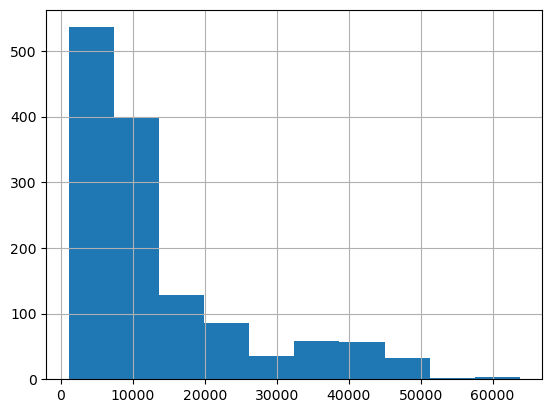

In [3]:
# plot histogram of charges
insurance['charges'].hist()

The `charges` columns is very right-skewed. Smaller charges are more common than larger ones. Which means the errors will not be centred around zero and ultimately affect the model's performance.  
A solution for this is to take the log of the charges.

<Axes: >

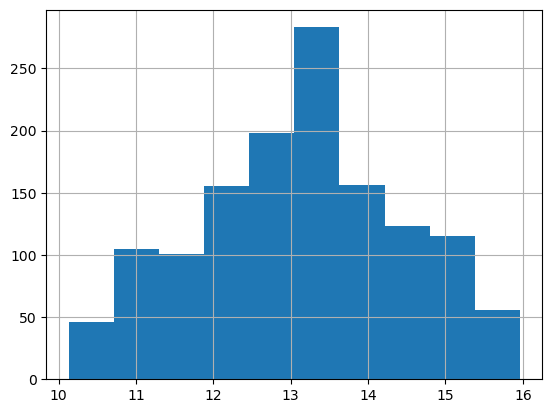

In [4]:
insurance['log_charges'] = np.log2(insurance['charges'])
insurance['log_charges'].hist()

The `log_charges` column has a much more normal distribution and therefore will be better to use in the model.

Next I will look at the correlations of the predictor columns. To do this I will first encode the categorical columns.

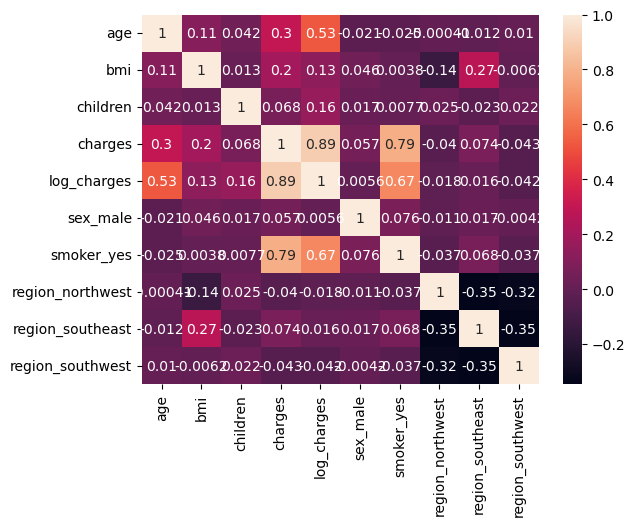

In [5]:
insurance_dummy = pd.get_dummies(insurance, drop_first=True)

correlations = insurance_dummy.corr()
sns.heatmap(correlations, annot=True, fmt='.2g')
plt.show()

From the heatmap it can be seen that `smoker` has a 79% correlation with `charges`. `age` has a 30% correlation and `bmi` has a 20% correlation.  
`children` has a smaller correlation with 6.8% and `sex` with 5.6%

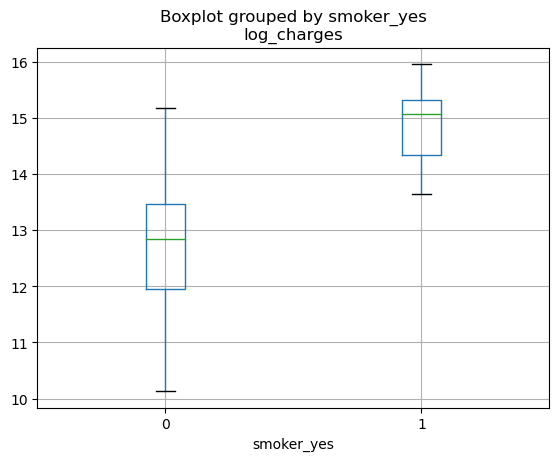

In [6]:
insurance_dummy.boxplot(column=['log_charges'],by='smoker_yes')
plt.show()

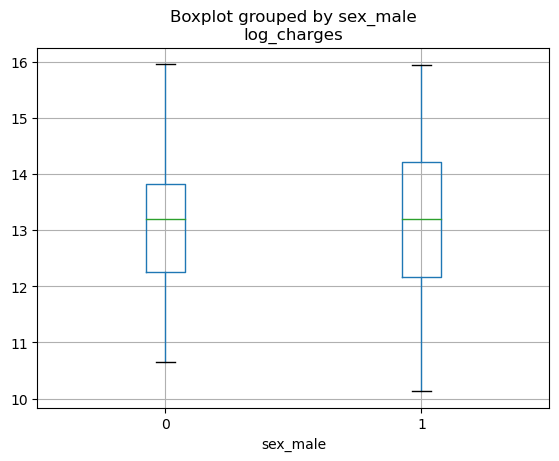

In [7]:
insurance_dummy.boxplot(column=['log_charges'],by='sex_male')
plt.show()

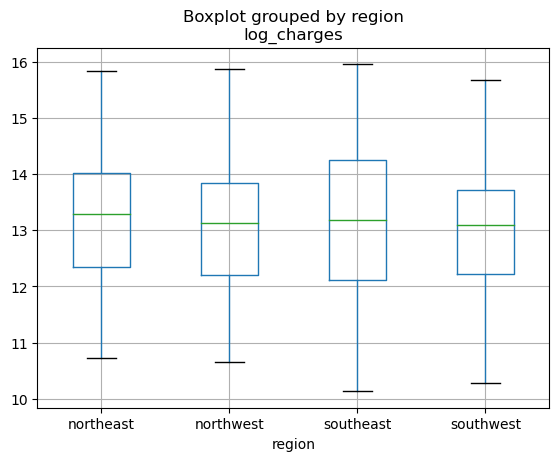

In [8]:
insurance.boxplot(column=['log_charges'],by='region')
plt.show()

From the boxplots it can be seen that smokers have a narrower distribution than non-smokers and higher costs overall. Males have a slightly wider distribution than females, but not markedly. There appears to be not significant difference in the charges across the regions.

From the above exploration and because of their higher correlation with charges I will include the following predictors in the model:
- `age`
- `smoker`
- `bmi`

### Dividing the Data

Next I will split the data into a train and test set. The train set is used to train the model and estimate the regression coefficients. The test set is used to make prediction and assess the model's performance.  
I will split the data into 75% train and 25% test.

In [9]:
X = insurance_dummy[["age","bmi","smoker_yes"]]
y = insurance_dummy["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=300)

### Building the Model

Next I will build the model and perform intial calculations to display the R2 value and MSE. These can be compared with the same values on the test set later to assess performance.

In [10]:
# train the model
model = LinearRegression()
model.fit(X_train, y_train)

# create predictions
train_predictions = model.predict(X_train)

# calculate scores
R2_train = r2_score(y_train, train_predictions)
MSE_train = mean_squared_error(y_train, train_predictions)
RMSE_train = mean_squared_error(y_train, train_predictions, squared=False)

# print
print(f'the R2 score is: {R2_train:.2g}. The MSE is: {MSE_train:.2g}. The RMSE is: {RMSE_train:.2g}')

the R2 score is: 0.75. The MSE is: 0.44. The RMSE is: 0.66


The intercept does not give any usable insight with this data.  
The slopes would indicate that `smoker` has more of an impact on `charge` than the other two predictors.  
The intial R2 and MSE scores are good. They show the model does a reasonable job at predicting charges on the training set.

### Residual Diagnostics

Before moving on further to refining the model. I will examine the model to ensure the assumptions of linear regression are met. I will plot to the residuals against the predictions to determine if  
a) the residuals are centred around `0`  
b) the variance of the residuals is constant

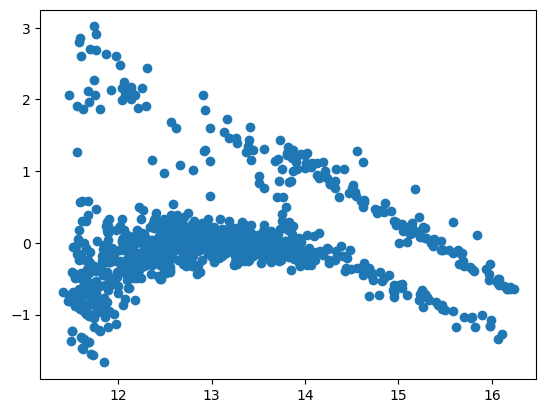

In [11]:
# calculate residuals
residuals = y_train - train_predictions

# plot the residuals against predictions
plt.scatter(train_predictions, residuals)
plt.show()

Whilst a large number of predictions are centre on the zero residual, there is some violation to the assumption. As predictions get larger the residuals trend downwards.  
The model is by no means unusable, but the assumptions of linear regression have been put into question.

### Interpreting the Model

The benefits of a linear regression model is that we can interpret the estimated coefficients in terms of how the predictors relate to the outcome.

In [12]:
print('log_charge:',model.intercept_)
print('charge:',np.exp(model.intercept_))

log_charge: 10.293992093897636
charge: 29554.52359613022


The intercept of the model is `10.29` with the equivilent charge of `29,554`. Meaning when all the predictors `age`, `bmi`, `smoker` equal zero the average charge is `29,554`.  
Whilst an individual can have an age of 0 and be a non-smoker, it is not possible to have a bmi of 0. This particular value is not meaningful is this circumstance.

In [13]:
print('coefficients:',model.coef_)
print('coefficients on regular scale:',np.exp(model.coef_))

coefficients: [0.05132116 0.01191881 2.21388051]
coefficients on regular scale: [1.05266091 1.01199012 9.15115873]


The above coeeficients show an increase in `age` by 1 results in and increase in `log_charges` by 0.05.  
An increase in `bmi` by 1 results in and increase in `log_charges` by 0.01.  
An increase in `smoker_yes` by 1 results in and increase in `log_charges` by 2.21. 

On the regular scale:   
An increase in `age` results in about a 5% increase in `charges`.  
An increase in `bmi` results in about a 1% increase in `charges`.  
A `smoker` value of `yes` results in about a 915% increase in `charges`.

### Final Model Evaluation

I will now use the test set to evaluate the model.

In [14]:
# make test predictions
test_predictions = model.predict(X_test)

# calculate scores
R2_test = r2_score(y_test, test_predictions)
MSE_test = mean_squared_error(y_test, test_predictions)
RMSE_test = mean_squared_error(y_test, test_predictions, squared=False)

# print results and comparisons
print(f'The R2 score for the test set is: {R2_test:.2f}, for the train set it was: {R2_train:.2f}')
print(f'The MSE for the test set is: {MSE_test:.2f}, for the train set it was: {MSE_train:.2f}')
print(f'The RMSE for the test set is: {RMSE_test:.2f}, for the train set it was: {RMSE_train:.2f}')
print(f'The RMSE on the normal scale for the test set is: {np.exp(RMSE_test):.2f}, for the train set it was: {np.exp(RMSE_train):.2f}')

The R2 score for the test set is: 0.74, for the train set it was: 0.75
The MSE for the test set is: 0.49, for the train set it was: 0.44
The RMSE for the test set is: 0.70, for the train set it was: 0.66
The RMSE on the normal scale for the test set is: 2.02, for the train set it was: 1.93


### Drawing Conclusions

The R2 score suggests the model accounts for 74% of the variability in the test set, this is similar to the score for the train set.  

The MSE scores are very similar at `0.49` and `0.44` this would suggest the model has not been overfit.  
When predictions were made on the test set the average error was `2.02` in terms of the original `charges` column.

The residual diagnostics would suggest the model under-estimates any higher charges and is better and predicting lower charges. 

In the future the model could be improved by including more complex terms in the regression, such as interactions or quadratic terms.